In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Ckpt paths
llama2_path = '/scratch/sux7mp/saved_models/llama2.pth'
memit_path = '/scratch/sux7mp/saved_models/checkpoint_20240126_064240.pth'
memit_wanda55_path = '/scratch/sux7mp/saved_models/checkpoint_20240131_104241.pth'
compress_first = '/scratch/sux7mp/saved_models/checkpoint_20240201_111754.pth'

ckpt_paths = [llama2_path, memit_path, memit_wanda55_path, compress_first]
layers = [3, 4, 5]  # Layers to plot
titles = ["Original model", "After editing", "E→C", "C→E"]  # Titles for each model


In [3]:
def get_layer_params(ckpt_paths, layers, sample_size=10000):
    layer_params_dict = {}

    for layer_number in layers:
        layer_key_prefix = f'model.layers.{layer_number}.'
        layer_params_dict[layer_number] = []

        for ckpt_path in ckpt_paths:
            state_dict = torch.load(ckpt_path, map_location='cuda')
            layer_params = []

            for key in state_dict:
                if key.startswith(layer_key_prefix):
                    tensor = state_dict[key].flatten().to(dtype=torch.float16)
                    # Random sampling
                    if tensor.numel() > sample_size:
                        indices = np.random.choice(tensor.numel(), sample_size, replace=False)
                        sampled_params = tensor[torch.tensor(indices)].cpu().numpy()
                    else:
                        sampled_params = tensor.cpu().numpy()

                    layer_params.extend(sampled_params)

            layer_params_dict[layer_number].append(layer_params)
    
    return layer_params_dict
    
layer_params_dict = get_layer_params(ckpt_paths, layers)

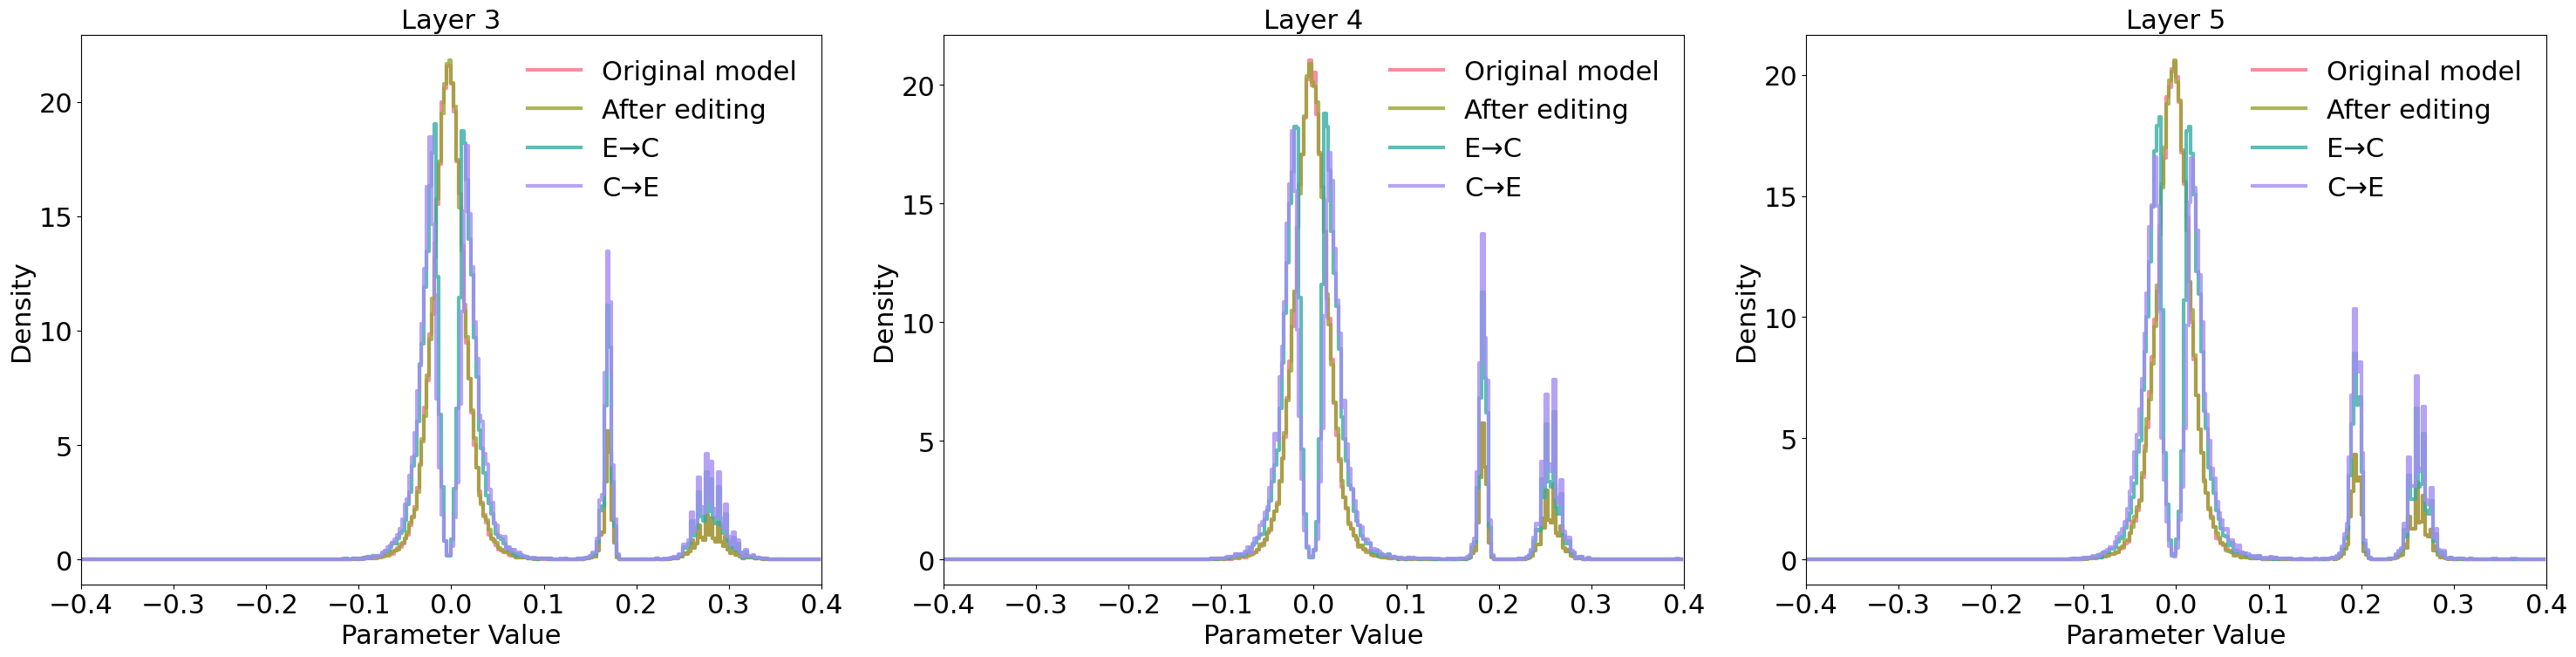

In [44]:
import seaborn as sns
import matplotlib as mpl
 # Increase global font sizes
mpl.rcParams['font.size'] = 22  # Adjust as needed
mpl.rcParams['axes.labelsize'] = 22  # x and y labels
mpl.rcParams['axes.titlesize'] = 22  # Title
mpl.rcParams['xtick.labelsize'] = 22  # x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 22  # y-axis tick labels
mpl.rcParams['legend.fontsize'] = 22  # Legend

import numpy as np
palette = sns.color_palette("husl", len(titles))  # "husl" is just one option

def plot_layer_distributions(layer_params_dict, titles, save_path):
    num_layers = len(layer_params_dict)
    fig, axs = plt.subplots(1, num_layers, figsize=(10 * num_layers, 8))

    for i, (layer_number, layer_params_list) in enumerate(layer_params_dict.items()):
        ax = axs[i] if num_layers > 1 else axs

        for j, layer_params in enumerate(layer_params_list):
            if 'c' in titles[j].lower():
                layer_params = [param for param in layer_params if param != 0]
            
            counts, bin_edges = np.histogram(layer_params, bins=300, range=(-0.4, 0.4), density=True)
            ax.step(bin_edges[:-1], counts, color=palette[j], linewidth=3, alpha=0.8, label=titles[j])

            # Save histogram data
            hist_data = np.vstack((bin_edges[:-1], counts)).T
            # np.savetxt(f"{save_path}_layer{layer_number}_title{j}.csv", hist_data, delimiter=",", header="bin_edge,density")

        ax.set_title(f'Layer {layer_number}')
        ax.legend(frameon=False)
        ax.set_xlabel('Parameter Value')
        ax.set_ylabel('Density')
        ax.grid(False)
        ax.set_xlim(-0.4, 0.4)

    plt.tight_layout()
    plt.savefig('figures/params.pdf', format='pdf', dpi=300, bbox_inches='tight')  # Save as PDF
    plt.show()

plot_layer_distributions(layer_params_dict, titles, 'temp/')

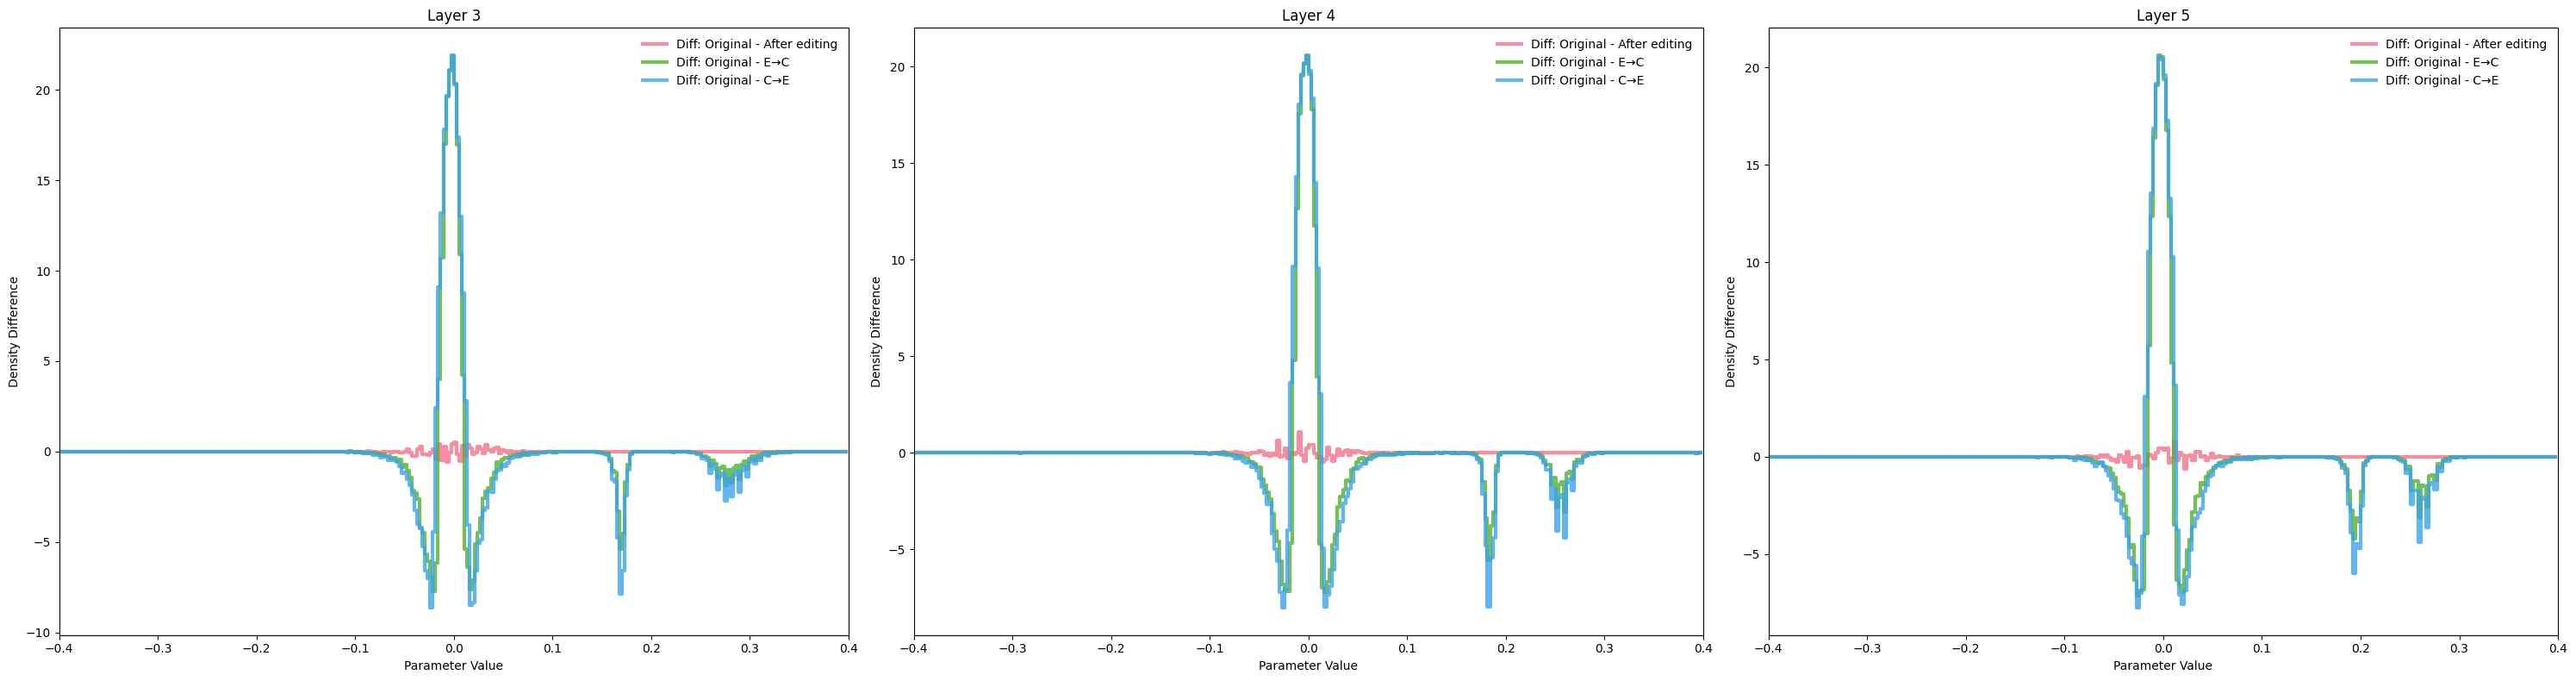

In [10]:
palette = sns.color_palette("husl", 3)  # Adjusted to 3 because we are plotting differences for 3 models

def plot_layer_distributions_diff(layer_params_dict, titles, save_path):
    num_layers = len(layer_params_dict)
    fig, axs = plt.subplots(1, num_layers, figsize=(10 * num_layers, 8))

    for i, (layer_number, layer_params_list) in enumerate(layer_params_dict.items()):
        ax = axs[i] if num_layers > 1 else axs
        original_params = layer_params_list[0]  # Original model's parameters

        for j in range(1, len(layer_params_list)):  # Start from 1 to skip the original model
            layer_params = layer_params_list[j]
            
            if 'c' in titles[j].lower():
                layer_params = [param for param in layer_params if param != 0]

            # Calculate histograms
            counts_orig, bin_edges = np.histogram(original_params, bins=300, range=(-0.4, 0.4), density=True)
            counts_other, _ = np.histogram(layer_params, bins=300, range=(-0.4, 0.4), density=True)

            # Calculate difference in densities
            counts_diff = counts_orig - counts_other

            # Plotting the difference
            ax.step(bin_edges[:-1], counts_diff, color=palette[j-1], linewidth=3, alpha=0.8, label=f'Diff: Original - {titles[j]}')

        ax.set_title(f'Layer {layer_number}')
        ax.legend(frameon=False)
        ax.set_xlabel('Parameter Value')
        ax.set_ylabel('Density Difference')
        ax.grid(False)
        ax.set_xlim(-0.4, 0.4)

    plt.tight_layout()
    # plt.savefig(f'{save_path}params_diff.pdf', format='pdf', dpi=300, bbox_inches='tight')  # Save as PDF
    plt.show()

plot_layer_distributions_diff(layer_params_dict, titles, 'temp/')

NameError: name 'j' is not defined

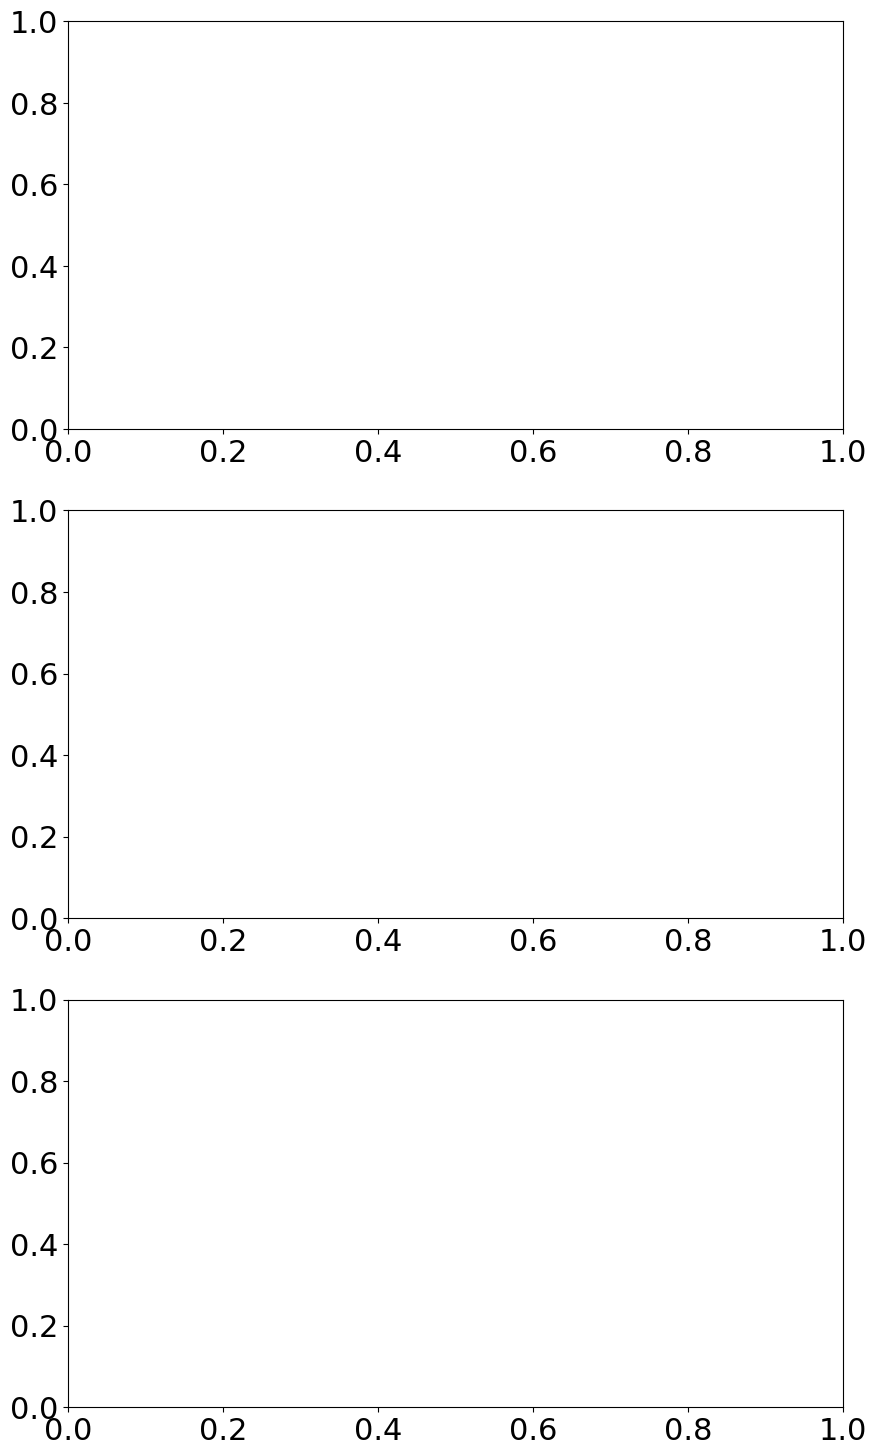

In [38]:
import matplotlib.pyplot as plt

def plot_selected_checkpoints(layer_params_dict, titles, checkpoint_combinations, save_path):
    num_layers = len(layer_params_dict)
    fig, axs = plt.subplots(num_layers, 1, figsize=(10, 6 * num_layers))

    for i, (layer_number, layer_params_list) in enumerate(layer_params_dict.items()):
        ax = axs[i] if num_layers > 1 else axs

        for checkpoints in checkpoint_combinations:
            for checkpoint_idx in checkpoints:
                if checkpoint_idx < len(layer_params_list):
                    layer_params = layer_params_list[checkpoint_idx]

                    # Exclude values at 0 for compression layers
                    if 'c' in titles[checkpoint_idx].lower():
                        layer_params = [param for param in layer_params if param != 0]

                    # Plot histogram for each individual checkpoint
                    counts, bin_edges = np.histogram(layer_params, bins=300, range=(-0.4, 0.4), density=True)
                    ax.step(bin_edges[:-1], counts, color=palette[j], linewidth=3, alpha=0.8, label=f"Checkpoint {checkpoint_idx+1}")

                    # Save histogram data
                    hist_data = np.vstack((bin_edges[:-1], counts)).T
                    np.savetxt(f"{save_path}_layer{layer_number}_checkpoint_{checkpoint_idx+1}.csv", hist_data, delimiter=",", header="bin_edge,density")

        ax.set_xlabel('Parameter Value')
        ax.set_ylabel('Density')
        ax.grid(False)
        ax.set_xlim(-0.4, 0.4)
        ax.legend()

    plt.tight_layout()
    plt.show()
checkpoint_combinations = [[1, 2, 3], [1, 2, 4]]

plot_selected_checkpoints(layer_params_dict, titles, checkpoint_combinations, 'temp/')

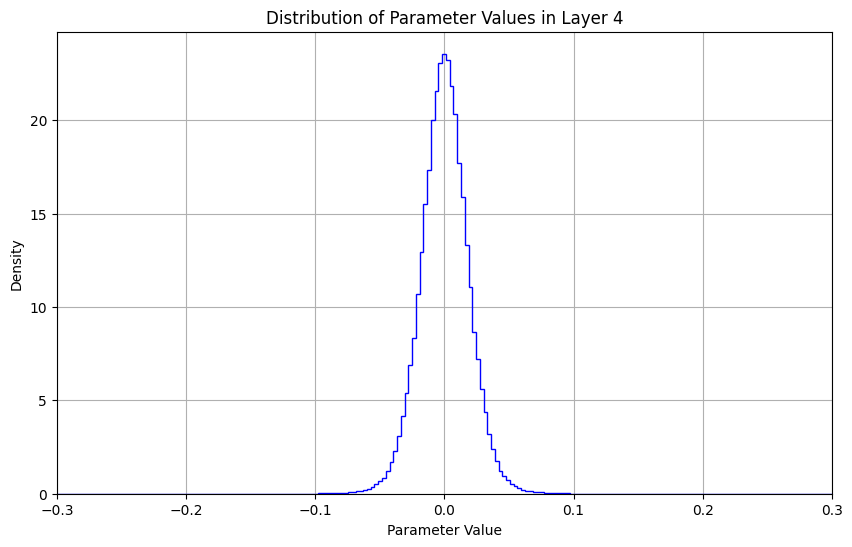

In [14]:
# Plotting the distribution of the parameters
plt.figure(figsize=(10, 6))

# Density histogram without filling under the curve
plt.hist(layer_params, bins=500, color='blue', alpha=1.0, density=True, histtype='step')

plt.title(f'Distribution of Parameter Values in Layer {layer_number + 1}')
plt.xlabel('Parameter Value')
plt.ylabel('Density')
plt.grid(True)

# Limit x-axis range
plt.xlim(-0.3, 0.3)

plt.show()

In [4]:
# The key for the 4th layer weights in Llama2 model 
# (Replace 'layer4.weight' with the correct key for your model)
layer_key = f'model.layers.{3}.weight'  # Indexing starts from 0, so 3 refers to the 4th layer

# Extract and flatten the parameters of the 4th layer
layer_params = memit_model[layer_key].flatten().numpy()

# Plotting the distribution of the parameters
plt.figure(figsize=(10, 6))
plt.hist(layer_params, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Parameter Values in the 4th Layer')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

KeyError: 'model.layers.3.weight'